In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
import warnings
warnings.filterwarnings('ignore')

# DATA Preparation

In [611]:
data = pd.read_csv('full_data_labeled.csv')
data = data.drop(columns=['CI SCORE GLOVE','CI SCORE GLOVE 2','CI SCORE GLOVE 50','CI MEAN SCORES']).replace(np.nan,'None')
print(data.shape)

df = data.copy()
df['LabelEncoded'] = df['Label'].replace(['no','yes'],[0,1])
df = df.drop(columns=['Vulnerability Type(s)','Vulnerability Name','Kmeans_clusters','CI SCORE','Label'])
df = df[df['Authentication']!='Single system']
df = df[df['Access']!='Unknown']
df = df.reset_index().drop(columns=['level_0'])
print(df.shape)

numerical_cols = ['Score','Number Of Related Vulnerabilities']
categorical_cols = ['Access','Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']
# categorical_cols = ['Vulnerability Type(s)', 'Vulnerability Name', 'Access',
#                     'Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']
label = ['LabelEncoded']

ohe = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    df[numerical_cols]
],axis=1)

from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
std_scaler = stdScaler.fit_transform(df[numerical_cols])
ohe_std_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(std_scaler,columns=numerical_cols)
],axis=1)
# Scaling all features
std_scaler_all = stdScaler.fit_transform(ohe)
ohe_all_scaled = pd.DataFrame(std_scaler_all,columns=ohe.columns)

from sklearn.preprocessing import MinMaxScaler 
mnScaler = MinMaxScaler()
mn_scaler = mnScaler.fit_transform(df[numerical_cols])
ohe_mn_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(mn_scaler,columns=numerical_cols)
],axis=1)
print(ohe_mn_scaled.shape)

from imblearn.under_sampling import RandomUnderSampler
X = ohe_mn_scaled
y = df[label]
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)



(61698, 14)
(52634, 10)
(52634, 19)


In [612]:
print(y.value_counts())
print(y_rus.value_counts())

LabelEncoded
1               43818
0                8816
Name: count, dtype: int64
LabelEncoded
0               8816
1               8816
Name: count, dtype: int64


# Models 
- MultinomialNB: 0.94 , BernoulliNB: 0.96 , CategoricalNB: 0.89 , LinearSVC: 0.93 , NuSVC: 0.91


In [613]:

from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc


In [584]:

def train_model(X,Y,model):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=2)
    cv = ShuffleSplit(test_size=0.2)
    cv_results = cross_validate(model,X=X_train,y=y_train,cv=cv,return_train_score=True, error_score='raise')
    print("Train Score:", f"{cv_results['train_score'].mean():.4f}")
    
    cross_val_scores = cross_val_score(model,X=X_train,y=y_train, cv=cv)
    print("Mean CV Score:", f"{cross_val_scores.mean():.4f}")
    
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print("Train Score:", f"{train_score:.4f}")
    print("Test Score:", f"{test_score:.4f}")
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(f"{accuracy_score(y_test,y_pred):.4f}")
    

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Display confusion matrix values
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()




## Test Imbalanced data

In [585]:

# train_model(
#     X = ohe_std_scaled,
#     Y = df[label],
#     model = ComplementNB()
#     )


## Test resampled data - RandomUnderSampling

Train Score: 0.9810
Mean CV Score: 0.9810
Train Score: 0.9808
Test Score: 0.9782
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1740
           1       0.98      0.98      0.98      1787

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527

[[1705   35]
 [  42 1745]]
0.9782


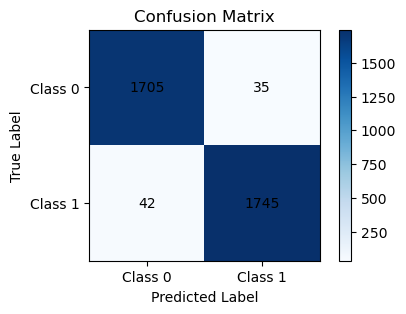

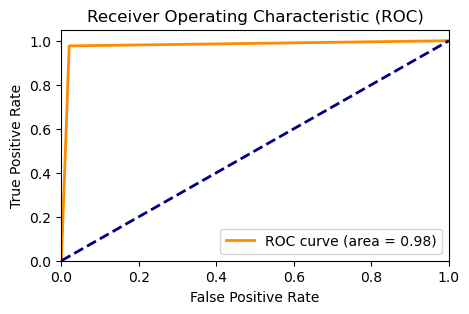

In [698]:

# Classification models :
from sklearn.neighbors import NearestCentroid # Test Score: 0.91  # Tuning: (shrink_threshold=0.3) = 0.92
from sklearn.naive_bayes import MultinomialNB # Test Score: 0.94  # Tuning: (alpha=10, fit_prior=False) = 0.95
from sklearn.naive_bayes import BernoulliNB # Test Score: 0.90    # Tuning: 0.99 overtif so use default
from sklearn.naive_bayes import ComplementNB # Test Score: 0.95   # Tuning: no effect so use default
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # Test Score: 0.72 # Tuning: (reg_param=0.1, store_covariance=True) = 0.95

from sklearn.naive_bayes import CategoricalNB # Test Score: 0.90
from sklearn.svm import NuSVC # Test Score: 0.91 - exe:7min


# RandomUnderSampling
train_model(
    X = X_rus,
    Y = y_rus,
    model = CategoricalNB()
    )



## Hyperparams Tuning for each model

Train Score: 0.9770
Mean CV Score: 0.9761
Train Score: 0.9768
Test Score: 0.9759
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1740
           1       0.98      0.97      0.98      1787

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527

[[1711   29]
 [  56 1731]]
0.9759


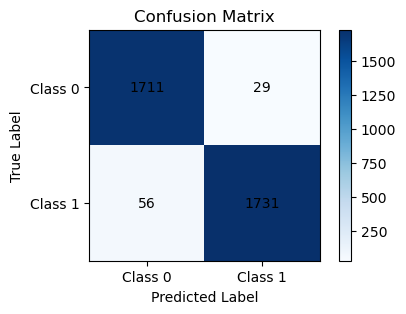

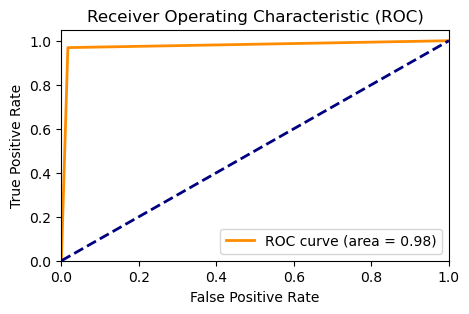


=========	After Tuning	==========

Best hyperparameters: {'shrink_threshold': 0.01}
Best estimator: NearestCentroid(shrink_threshold=0.01)
Best Score: 0.9768876255962523
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1740
           1       0.98      0.97      0.98      1787

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527

0.9759001984689538


In [595]:

def tuning(X, Y, clf, param_grid):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
    grid_search = GridSearchCV(clf, param_grid, cv=10)
    grid_search.fit(X_train, y_train)
    
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best estimator:", grid_search.best_estimator_)
    print("Best Score:", grid_search.best_score_)

    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    

param_grid_NearestCentroid = {
    'shrink_threshold': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
}#Best estimator: NearestCentroid(shrink_threshold=0.3)

param_grid_MultinomialNB = {
    'alpha': [0, 0.1, 1.0, 2.0, 10, 100, 1000],
    'fit_prior': [True,False]
}#Best estimator: MultinomialNB(alpha=10, fit_prior=False)

param_grid_QuadraticDiscriminantAnalysis = {
    'reg_param': [0.0, 0.1, 0.2],
    'store_covariance': [True, False],
}#Best estimator: QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)



# Before Tuning
train_model(X = X_rus,
            Y = y_rus,
            model = NearestCentroid())
print('\n=========\tAfter Tuning\t==========\n')
# After Tuning
tuning(X = X_rus,
       Y = y_rus,
       clf = NearestCentroid(),
       param_grid = param_grid_NearestCentroid)


## Voting Classifier

In [596]:

from sklearn.ensemble import VotingClassifier

nc_clf = NearestCentroid(shrink_threshold=0.3)
mulnb_clf = MultinomialNB(alpha=10, fit_prior=False)
qda_clf = QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)
bernb_clf = BernoulliNB()
comnb_clf = ComplementNB()
# NN_clf = keras.Sequential([
#     keras.layers.Dense(1,input_shape=(X_rus.shape[1],),activation='sigmoid')
# ]).compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# NN_clf.fit(x_train, y_train, epochs=3)


voting_clf = VotingClassifier([
    ('nc_clf',nc_clf),
    ('mulnb_clf',mulnb_clf),
    ('qda_clf',qda_clf),
    ('bernb_clf',bernb_clf),
    ('comnb_clf',comnb_clf),
])


X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2)
nc_clf.fit(X_train,y_train)
mulnb_clf.fit(X_train,y_train)
qda_clf.fit(X_train,y_train)
bernb_clf.fit(X_train,y_train)
comnb_clf.fit(X_train,y_train)

print("nc_clf : ",nc_clf.score(X_test,y_test))
print("mulnb_clf : ",mulnb_clf.score(X_test,y_test))
print("qda_clf : ",qda_clf.score(X_test,y_test))
print("bernb_clf : ",bernb_clf.score(X_test,y_test))
print("comnb_clf : ",comnb_clf.score(X_test,y_test))
print("\n=================================")
voting_clf.fit(X_train,y_train)
print("voting_clf : ",voting_clf.score(X_test,y_test))
y_pred = voting_clf.predict(X_test)
print("voting_clf : ",accuracy_score(y_test,y_pred))


nc_clf :  0.9753331443152821
mulnb_clf :  0.9821377941593422
qda_clf :  0.9835554295435214
bernb_clf :  0.9804366316983272
comnb_clf :  0.9818542670825063

voting_clf :  0.9821377941593422
voting_clf :  0.9821377941593422


Train Score: 0.9509
Mean CV Score: 0.9473
Train Score: 0.9502
Test Score: 0.9479
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2013
           1       0.99      0.91      0.95      2112

    accuracy                           0.95      4125
   macro avg       0.95      0.95      0.95      4125
weighted avg       0.95      0.95      0.95      4125

[[1989   24]
 [ 191 1921]]
0.9479


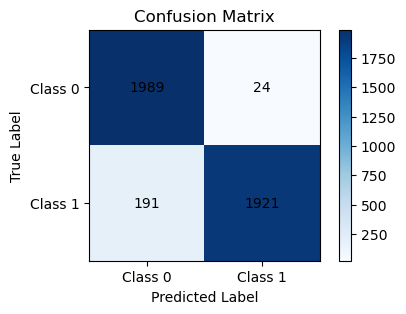

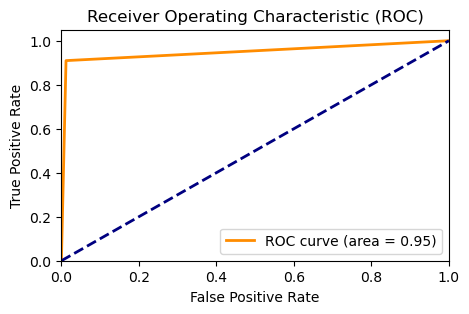

In [497]:

# RandomUnderSampling
train_model(
    X = X_rus,
    Y = y_rus,
    model = voting_clf
    )


## Prediction
- When you train a model on mixed data and apply one-hot encoding to it, you need to ensure that the new data you want to predict undergoes the same preprocessing steps as the training data.



In [692]:
X_test.head(1)
print('Prediction :',voting_clf.predict(X_test.head(1)))

cols = ['Access', 'Complexity', 'Authentication', 'Conf.', 'Integ.','Avail']
for col in cols:
    print(df[col].nunique(),'\t',df[col].unique())


Prediction : [1]
3 	 ['Remote' 'Local' 'Local Network']
3 	 ['Medium' 'Low' 'High']
2 	 ['Not required' 'Unknown']
3 	 ['None' 'Partial' 'Complete']
3 	 ['Partial' 'None' 'Complete']
3 	 ['None' 'Partial' 'Complete']


In [694]:

# df.sample(50).drop(columns=['index','LabelEncoded']).to_csv('sample_data_labeled_for_predictions.csv',index=False)
df_predictions = pd.read_csv('sample_data_labeled_for_predictions.csv').replace(np.nan,'None')

# asuuming that we get this data from a request
input_data = {
    'Access': ['Local'],
    'Complexity': ['High'],
    'Authentication': ['Not required'],
    'Conf.': ['Complete'],
    'Integ.': ['Partial'],
    'Avail': ['Complete'],
    'Score': [9.3],
    'Number Of Related Vulnerabilities': [413.0]
}
df_input_data = pd.DataFrame(input_data)

df_pred_input = pd.concat([df_predictions,df_input_data],axis=0).reset_index().drop(columns=['index'])
numerical_columns = df_pred_input.select_dtypes(include=['int', 'float']).columns
categorical_columns = df_pred_input.select_dtypes(exclude=['int', 'float']).columns

# process new input data for predict it
df_predictions_scaled = pd.concat([
    pd.get_dummies(df_pred_input[categorical_columns],dtype=float),
    pd.DataFrame(mnScaler.fit_transform(df_pred_input[numerical_columns]),columns=numerical_columns)
],axis=1)

new_input_processed = df_predictions_scaled.tail(1)
print(new_input_processed.shape)
new_input_processed

(1, 19)


,Access_Local,Access_Local Network,Access_Remote,Complexity_High,Complexity_Low,Complexity_Medium,Authentication_Not required,Authentication_Unknown,Conf._Complete,Conf._None,Conf._Partial,Integ._Complete,Integ._None,Integ._Partial,Avail_Complete,Avail_None,Avail_Partial,Score,Number Of Related Vulnerabilities
50,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.91358,0.017989


In [700]:
new_input_processed = df_predictions_scaled.tail(1)
voting_clf.predict(new_input)

array([1], dtype=int64)

## Test resampled data - OverSampling

In [110]:
# from imblearn.over_sampling import RandomOverSampler,SMOTE,KMeansSMOTE
    
# X = ohe_mn_scaled
# y = df[label]

# smote = SMOTE()
# ros = RandomOverSampler()
# kmsmote = KMeansSMOTE()

# X_smote, y_smote = smote.fit_resample(X, y)
# X_ros, y_ros = ros.fit_resample(X, y)
# X_kmsmote, y_kmsmote = kmsmote.fit_resample(X, y)


# #SMOTE
# train_model(
#     X = X_smote,
#     Y = y_smote,
#     model = MultinomialNB()
#     )
